In [1]:
import math
import random
import array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

In [2]:
from deap import tools, creator, base

## an illustrative MOP problem: Dent

$$
\begin{array}{rl}
\text{minimize} & f_1(\vec{x}),f_2(\vec{x}) \\
\text{such that} & f_1(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} + \sqrt{1 + (x_1 - x_2)^2} + x_1 -x_2\right) + d,\\
 & f_2(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} + \sqrt{1 + (x_1 - x_2)^2} - x_1 + x_2\right) + d,\\
\text{with}& d = \lambda e^{-\left(x_1-x_2\right)^2}\ (\text{generally }\lambda=0.85) \text{ and } \vec{x}\in \left[-1.5,1.5\right]^2.
\end{array}
$$

In [3]:
def dent(individual, labda=0.85):
    x1 = individual[0]
    x2 = individual[1]
    
    d = labda * math.exp(-(x1-x2)**2)
    
    f1 = 0.5 * (math.sqrt(1 + (x1 + x2)**2) + math.sqrt(1 + (x1 - x2)**2) + x1 - x2) + d
    f2 = 0.5 * (math.sqrt(1 + (x1 + x2)**2) + math.sqrt(1 + (x1 - x2)**2) - x1 + x2) + d
    return f1, f2

In [4]:
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)
toolbox = base.Toolbox()

In [6]:
def uniform(low, up, size=1):
    return [random.uniform(a, b) for a, b in zip([low,]*size, [up,]*size)]

In [7]:
BOUND_LOW = -1.5
BOUND_UP = 1.5
NDIM = 2
toolbox.register('attr_float', uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('evaluate', dent)

In [8]:
num_samples = 20
example_pop = toolbox.population(n=num_samples**NDIM)

### Replace population with manually generated samples (non-random)

In [10]:
x_samples = np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP-BOUND_LOW)/num_samples)
y_samples = np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP-BOUND_LOW)/num_samples)
xx, yy = np.meshgrid(x_samples, y_samples)
ind_samples = np.vstack((xx.flatten(), yy.flatten())).transpose()

for i, ind in enumerate(example_pop):
    ind[:] = ind_samples[i, :]

### Fitness assigment (note to use ind.fitness.values, so that it will call setValues to multiple weights)

In [11]:
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

### Visualize domination relationship between a given individual and the population

In [12]:
given_individual = toolbox.individual()
given_individual[0] = 0.5
given_individual[1] = 0.5
given_individual.fitness.values = toolbox.evaluate(given_individual)

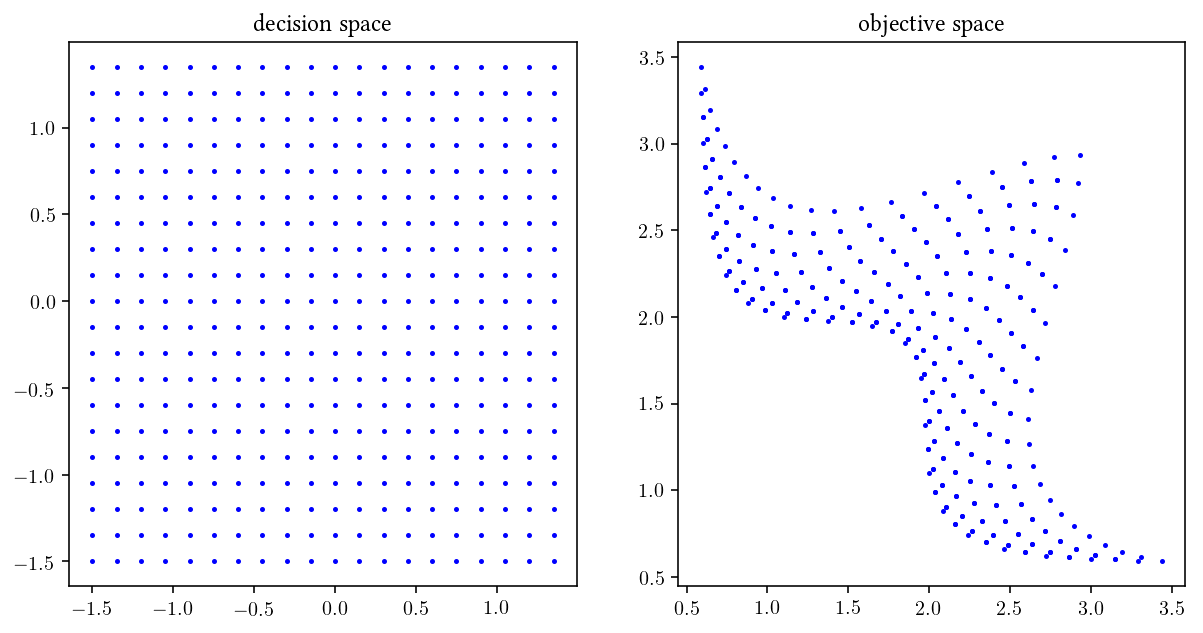

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('decision space')
for ind in example_pop:  plt.plot(ind[0], ind[1], 'b.', ms=3)

plt.subplot(1, 2, 2)
plt.title('objective space')
for ind in example_pop:  plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=3)

### Identify dominated individuals and dominator to the given individual (using dominates function of Fitness class)

In [14]:
dominated = [ind for ind in example_pop if given_individual.fitness.dominates(ind.fitness)]
dominators = [ind for ind in example_pop if ind.fitness.dominates(given_individual.fitness)]
others = [ind for ind in example_pop if not ind in dominated and not ind in dominators]

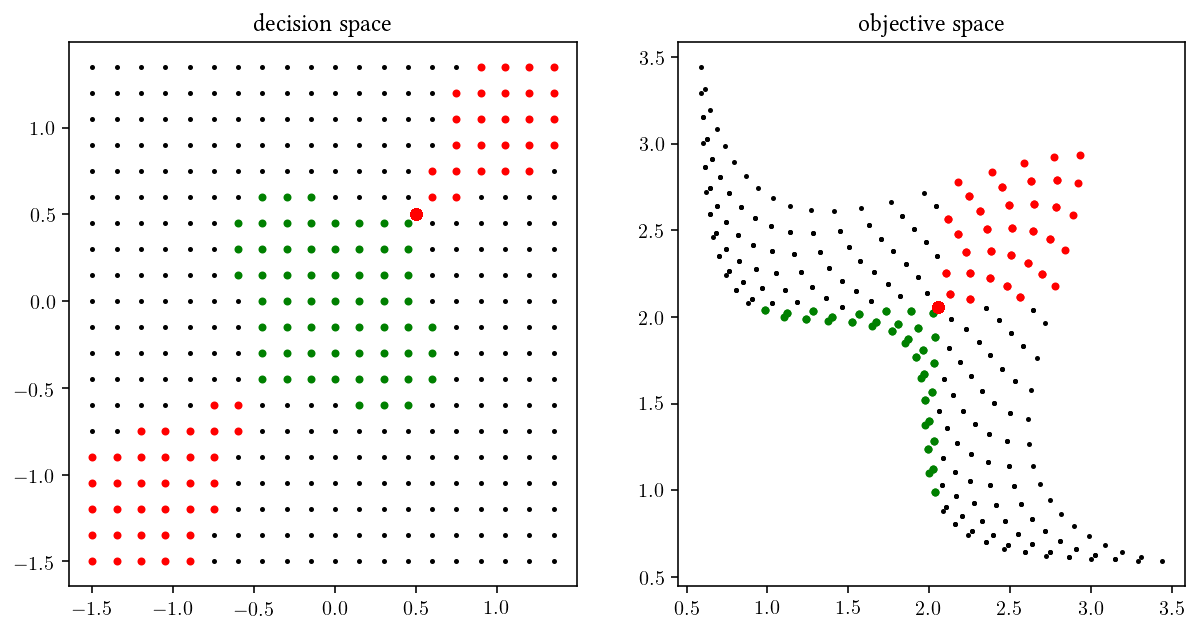

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('decision space')
for ind in dominated: plt.plot(ind[0], ind[1], 'r.', ms=6)
for ind in dominators: plt.plot(ind[0], ind[1], 'g.', ms=6)
for ind in others: plt.plot(ind[0], ind[1], 'k.', ms=3)
for ind in others: plt.plot(given_individual[0], given_individual[1], 'r.', ms=10)
    
plt.subplot(1, 2, 2)
plt.title('objective space')
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', ms=6)
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', ms=6)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in others: plt.plot(given_individual.fitness.values[0], given_individual.fitness.values[1], 'r.', ms=10)

### Identify non-dominated individuals

In [23]:
def pareto_front(population):
    '''
    an naive implementation of identifying pareto fron with MN**2 complexity
    M is the number of objectives
    N is the pupolation size
    '''
    pareto_set = []
    for ind1 in population:
        non_dominated = True
        for ind2 in population:
            if ind2.fitness.dominates(ind1.fitness):
                non_dominated = False
                break
        if non_dominated == True:
            pareto_set.append(ind1)
    return pareto_set

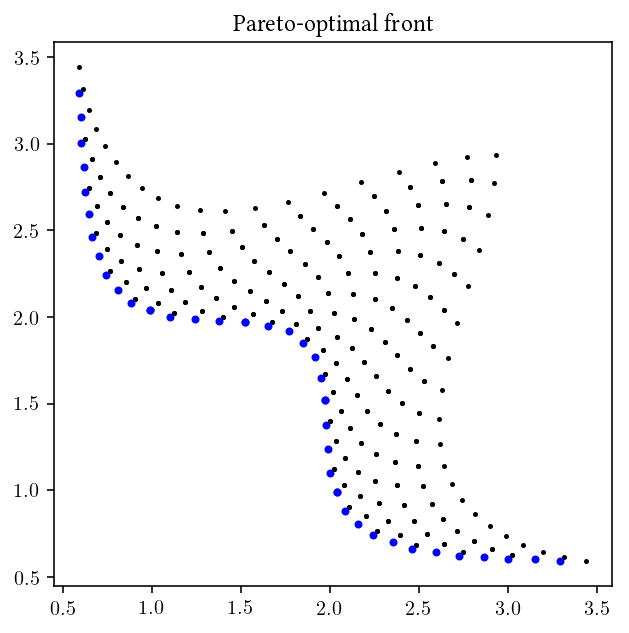

In [24]:
pareto_set = pareto_front(example_pop)

plt.figure(figsize=(5, 5))
plt.title('Pareto-optimal front')
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in pareto_set: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=6)

## NondominatedSorted implementation (NSGA2)

In [16]:
non_dom = tools.sortNondominated(example_pop, k=len(example_pop), first_front_only=True)[0]

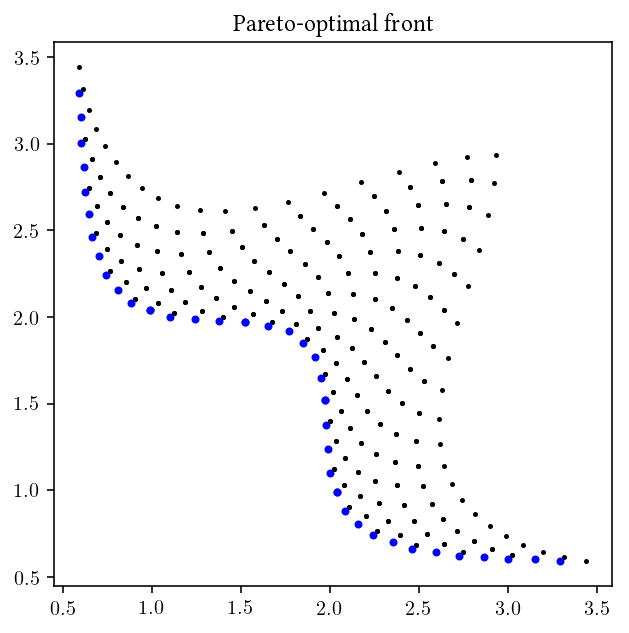

In [18]:
plt.figure(figsize=(5, 5))
plt.title('Pareto-optimal front')
for ind in example_pop: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3)
for ind in non_dom: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'b.', ms=6)